## Starting Dask cluster on HPC

Please refer to the [Dask-hpcconfig datarmor example Jupyter notebook](https://github.com/umr-lops/dask-hpcconfig/tree/main/docs/tutorials) to understand what the next three cells mean.  

In [2]:
import dask_hpcconfig
from distributed import Client

In [4]:
overrides = {}  # ,"cluster.c": n_worker_per_node }

cluster = dask_hpcconfig.cluster("datarmor-local", **overrides)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:50058' processes=14 threads=28, memory=60.00 GiB>

In [6]:
cluster.close()

In [7]:
memory_size = 12
n_worker_per_node = 120 // memory_size
# n_threads_per_worker=28//n_worker_per_node
print("nb workers we use for each node ", n_worker_per_node)  # ,n_threads_per_worker)
overrides = {
    "cluster.processes": n_worker_per_node
}  # ,"cluster.c": n_worker_per_node }

cluster = dask_hpcconfig.cluster("datarmor", **overrides)
client = Client(cluster)
cluster.scale(20)
client


nb workers we use for each node  10


/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


<Client: 'tcp://10.148.0.91:44657' processes=0 threads=0, memory=0 B>

In [8]:
!qstat -u todaka


datarmor0: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
5112381.datarmo todaka   mpi_1    jupyterhub  44432   1  28  115gb 02:00 R 00:59
5113142.datarmo todaka   mpi_1    STDIN       47662   1  28   60gb 24:00 R 00:14
5113234.datarmo todaka   mpi_1    jupyter_wo  32207   1  28  120gb 12:00 R 00:00
5113235.datarmo todaka   mpi_1    jupyter_wo   8362   1  28  120gb 12:00 R 00:00


# What is behind auto-kerchunk?

Auto-kerchunk was developed in 2021, following [this blog post example of applying kerchunk to NetCDF4 datas stored in S3](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685), by adapting it to an HPC environment and automating the creation of a kerchunk catalog of many existing datasets in an HPC datalake.

This notebook explains what is behind auto-kerchunk by manually proceeding with the creation of a kerchunk catalog (method 1), but it also indicates the recent update from the kerchunk capability 'auto_dask' (methods 2 and 3).

auto-kerchunk was created to 
- convert multiple NetCDF files to kerchunk catalogue, 
- make an intake catalogue to be able to submit a job to PBS scheduler, 
- auto-mate that using bash script and submit that to PBS scheduler.  

Please refer to [this documentation](https://pangeo-data.github.io/clivar-2022/pangeo101/chunking_introduction.html) to understand what kerchunk is (as well as what zarr and 'chunk' mean).


## We will use [MARC](https://marc.ifremer.fr) NetCDF4 datasets as an example.

First, we will list all the files we will use as 'file_pattern'.


In [5]:
import glob

# dir_url = 'https://data-dataref.ifremer.fr/marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/'
# file_pattern = 'MARC_F1-MARS3D-SEINE_*Z.nc'
dir_url = "/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/"
file_pattern = "MARC_F1-MARS3D-SEINE_20150101T*Z.nc"
file_paths = glob.glob(dir_url + file_pattern)
file_paths

['/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T1900Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T0400Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T1600Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T0100Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2000Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T1100Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2300Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2200Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_201

In [10]:
%%time
import xarray as xr

xr.open_mfdataset(file_paths, engine="h5netcdf", concat_dim=["time"],combine='nested', parallel=True)

CPU times: user 3.31 s, sys: 340 ms, total: 3.65 s
Wall time: 13.8 s


<xarray.Dataset>
Dimensions:      (ni: 413, nj: 183, ni_u: 413, nj_u: 183, ni_v: 413, nj_v: 183,
                  ni_f: 413, nj_f: 183, time: 24, level: 40)
Coordinates: (12/16)
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 409.0 410.0 411.0 412.0
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 409.5 410.5 411.5 412.5
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 409.0 410.0 411.0 412.0
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
    ...           ...
  * time         (time) datetime64[ns] 2015-01-01T19:00:00 ... 2015-01-01
  * level        (level) float32 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    longitude_u  (nj_u, ni_u) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    longitude_v  (nj_v, ni_v) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    latitude_u   (nj_u, ni_u) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    latitude_v   (nj_v, ni_v) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
Data variables: (12/15)
    SIG          (time, level) float32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    Csu_sig      (time, level) float32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    hc           (time, nj, ni) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    b            (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    theta        (time) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    H0           (time, nj, ni) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    ...           ...
    U            (time, nj_u, ni_u) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    V            (time, nj_v, ni_v) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    UZ           (time, level, nj_u, ni_u) float32 dask.array<chunksize=(1, 40, 183, 413), meta=np.ndarray>
    VZ           (time, level, nj_v, ni_v) float32 dask.array<chunksize=(1, 40, 183, 413), meta=np.ndarray>
    SAL          (time, level, nj, ni) float32 dask.array<chunksize=(1, 40, 183, 413), meta=np.ndarray>
    TEMP         (time, level, nj, ni) float32 dask.array<chunksize=(1, 40, 183, 413), meta=np.ndarray>
Attributes: (12/56)
    limi:                    0
    lima:                    412
    pasi:                    1
    ljmi:                    0
    ljma:                    182
    pasj:                    1
    ...                      ...
    product_name:            PREVIMER_F1-MARS3D-SEINE_20150101T1900Z.nc
    comment:                 Use of Meteo-France AROME meteorological data
    area:                    SEINE
    field_type:              1-hourly
    contact:                 cdoco-exploit@ifremer.fr
    quality_index:           0

## Converting Multiple NetCDF Files to a Kerchunk Catalogue

In this notebook, we will show three ways to convert multiple NetCDF files to one kerchunk catalogue.


### Method 1

We use `kerchunk.hdf.SingleHdf5ToZarr` with `dask.bag` to convert each NetCDF file to kerchunk catalogs, and then concatenate them with `kerchunk.combine.MultiZarrToZarr` to create a single kerchunk catalog. This workflow is used in the first version of auto-kerchunk.


In [5]:
%%time
import dask.bag as db
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr


def translate_dask(file):
    url = "file://" + file
    print("working on ", file)
    with fsspec.open(url) as inf:
        h5chunks = SingleHdf5ToZarr(inf, url, inline_threshold=100)
        return h5chunks.translate()


b = db.from_sequence(file_paths)
result_indask = b.map(translate_dask)
result = result_indask.compute()

from kerchunk.combine import MultiZarrToZarr

mzz = MultiZarrToZarr(
    result,
    concat_dims=["time"],
)
a = mzz.translate()

/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/kerchunk/hdf.py:436: UserWarning: The following excepion was caught and quashed while traversing HDF5
argument of type 'Empty' is not iterable
Traceback (most recent call last):
  File "/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/kerchunk/hdf.py", line 277, in _translator
    elif _is_netcdf_datetime(h5obj):
  File "/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/kerchunk/hdf.py", line 554, in _is_netcdf_datetime
    return units and "since" in units
TypeError: argument of type 'Empty' is not iterable

  warnings.warn(msg)
/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/kerchunk/hdf.py:436: UserWarning: The following excepion was caught and quashed while traversing HDF5
argument of type 'Empty' is not iterable
Traceback (most recent call last):
  File "/home/datawork-lops-iaocea/conda-env/pangeo-f

CPU times: user 596 ms, sys: 80 ms, total: 676 ms
Wall time: 2.97 s


### Method 2

We use `kerchunk.combine.auto_dask`  instead of `kerchunk.combine.MultiZarrToZarr`  as described above.


In [6]:
%%time
from kerchunk.combine import auto_dask
from kerchunk.hdf import SingleHdf5ToZarr


class PassThrough:
    def __init__(self, refs):
        self.refs = refs

    def translate(self):
        return self.refs


def translate_dask(file):
    url = "file://" + file
    print("working on ", file)
    with fsspec.open(url) as inf:
        h5chunks = SingleHdf5ToZarr(inf, url, inline_threshold=100)
        return h5chunks.translate()


b = db.from_sequence(file_paths)
result_indask = b.map(translate_dask)
result = result_indask.compute()

b = auto_dask(
    result,
    single_driver=PassThrough,
    # single_driver=JustLoad,
    single_kwargs={},  # "storage_options": {"anon": False}},
    mzz_kwargs={"concat_dims": ["time"]},
    n_batches=3,
)

CPU times: user 244 ms, sys: 4 ms, total: 248 ms
Wall time: 496 ms


### Method 3. 

We use `kerchunk.combine.auto_dask`  with `kerchunk.hdf.SingleHdf5ToZarr`  

`kerchunk.combine.auto_dask`  convert each NetCDF files into kerchunk catalogue and concatenate them to one kerchunk catalogue all at once, in parallel using dask.   

In [9]:
%%time
import warnings

warnings.filterwarnings("ignore")

from kerchunk.combine import auto_dask  # , SingleHdf5ToZarr
from kerchunk.hdf import SingleHdf5ToZarr

c = auto_dask(
    file_paths,
    single_driver=SingleHdf5ToZarr,
    # single_driver=JustLoad,
    single_kwargs={},  # "storage_options": {"anon": False}},
    mzz_kwargs={"concat_dims": ["time"]},
    n_batches=3,
)

CPU times: user 416 ms, sys: 132 ms, total: 548 ms
Wall time: 4.1 s


## Loading data to Xarray using kerchunk



In [15]:
%%time
import xarray as xr

ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": c,
        },
        "consolidated": False,
    },
    chunks={},
)
ds

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.6 ms


<xarray.Dataset>
Dimensions:      (time: 24, nj: 183, ni: 413, nj_u: 183, ni_u: 413, nj_v: 183,
                  ni_v: 413, level: 40, ni_f: 413, nj_f: 183)
Coordinates: (12/16)
    latitude     (time, nj, ni) float64 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    latitude_u   (time, nj_u, ni_u) float64 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    latitude_v   (time, nj_v, ni_v) float64 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
  * level        (level) float32 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    longitude    (time, nj, ni) float64 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    longitude_u  (time, nj_u, ni_u) float64 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    ...           ...
  * ni_v         (ni_v) float32 0.0 1.0 2.0 3.0 4.0 ... 409.0 410.0 411.0 412.0
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
  * time         (time) datetime64[ns] 2015-01-01 ... 2015-01-01T23:00:00
Data variables:
    H0           (time, nj, ni) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    HX           (time, nj_u, ni_u) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    HY           (time, nj_v, ni_v) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    SAL          (time, level, nj, ni) float32 dask.array<chunksize=(1, 28, 129, 290), meta=np.ndarray>
    TEMP         (time, level, nj, ni) float32 dask.array<chunksize=(1, 28, 129, 290), meta=np.ndarray>
    U            (time, nj_u, ni_u) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    UZ           (time, level, nj_u, ni_u) float32 dask.array<chunksize=(1, 28, 129, 290), meta=np.ndarray>
    V            (time, nj_v, ni_v) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    VZ           (time, level, nj_v, ni_v) float32 dask.array<chunksize=(1, 28, 129, 290), meta=np.ndarray>
    XE           (time, nj, ni) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
    hc           (time, nj, ni) float32 dask.array<chunksize=(1, 183, 413), meta=np.ndarray>
Attributes: (12/56)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    NCO:                     4.0.6
    arakawa_grid_type:       C1
    area:                    SEINE
    comment:                 Use of Meteo-France AROME meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    ...                      ...
    source:                  MARS MANGAE2500-AGRIF
    southernmost_latitude:   49.2424
    start_date:              2015-01-01T19:00:00Z
    stop_date:               2015-01-01T19:00:00Z
    title:                   PREVIMER F1 MANGAE2500 AGRIF hindcast
    westernmost_longitude:   -1.4598

**Using kerchunk + `xarray.open_dataset` accomplishes the same thing as using `xarray.open_mfdataset`, but as you will see from the time it takes, `xarray.open_dataset` is much faster with kerchunk.**


In [16]:
%%time
data = ds.TEMP.isel(level=10).mean(dim="nj").mean(dim="ni").compute()

CPU times: user 308 ms, sys: 16 ms, total: 324 ms
Wall time: 380 ms


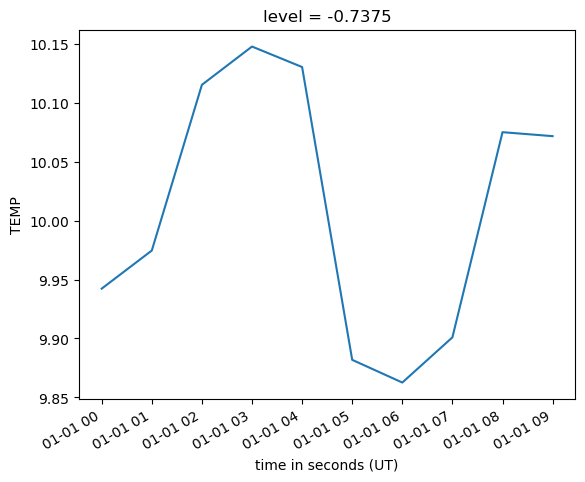

In [13]:
data.plot()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.795258 to fit


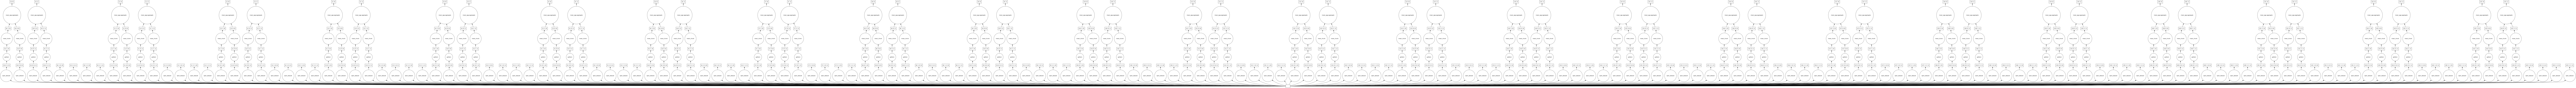

In [20]:
ds.TEMP.isel(level=10).mean(dim="nj").data.visualize()

In [21]:
ds.TEMP.isel(level=10).mean(dim="time").data.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.795258 to fit


## Intake
above `xarray.open_dataset` the code is is very long.... Lets use intake to make it simpple


## 

In [ ]:
import ujson

jsonfile = "test.json.zstd"
storage_options = {"compression": "zstd"}
# with open(jsonfile, mode='w') as f :
#    json.dump(out, f)

with fsspec.open(jsonfile, mode="wt", **(storage_options or {})) as f:
    ujson.dump(a, f)

In [ ]:
%%time
import xarray as xr

test = xr.open_dataset(
    "reference://",
    engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": "file:///home1/datawork/todaka/git/auto-kerchunk/notebooks/test.json.zstd",
            "target_options": {"compression": "zstd"},
        },
        "consolidated": False,
    },
    chunks={"time": 1, "level": "auto", "ni": "auto", "nj": "auto"},
)
test

In [ ]:
%%time
data = test.TEMP.isel(level=10).mean(dim="ni").mean(dim="nj").compute()

In [ ]:
data.plot()

In [4]:
xr.open_mfdataset("/home/datawork-WW3/HINDCAST/GLOBMULTI_ERA5_GLOBCUR_01/GLOB-30M/1993/FIELD_NC/LOPS_WW3-GLOB-30M_19931*.nc"
                 )
                

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 323, time: 736, f: 22)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * latitude   (latitude) float32 -78.0 -77.5 -77.0 -76.5 ... 82.0 82.5 83.0
  * time       (time) datetime64[ns] 1993-10-01 ... 1993-12-31T21:00:00
  * f          (f) float32 0.04102 0.04512 0.04963 ... 0.2509 0.276 0.3036
Data variables: (12/87)
    MAPSTA     (time, latitude, longitude) int16 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    dpt        (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    ucur       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    vcur       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    ...         ...
    uubr       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    vubr       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    mssu       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    mssc       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    mssd       (time, latitude, longitude) float32 dask.array<chunksize=(248, 323, 720), meta=np.ndarray>
    p2l        (time, f, latitude, longitude) float32 dask.array<chunksize=(248, 22, 323, 720), meta=np.ndarray>
Attributes: (12/102)
    WAVEWATCH_III_version_number:     7.00
    WAVEWATCH_III_switches:           F90 NOGRB NC4 SCRIP SCRIPNC SHRD PR3 UQ...
    SIN4 namelist parameter BETAMAX:  1.75
    title:                            WAVEWATCH-III HINDCAST
    netcdf_version:                   4.5.2
    product_name:                     LOPS_WW3-GLOB-30M_199310.nc
    ...                               ...
    P2SF:                             1
    E3D:                              1
    I1P2SF:                           3
    I2P2SF:                           24
    start_date:                       1993-10-01 00:00:00
    stop_date:                        1993-10-31 21:00:00